In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2024-02-08 21:09:43.058427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 21:09:43.058481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 21:09:43.059338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the dataset
data = pd.read_csv("/kaggle/input/retail-sales-data/sales_data.csv")

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

In [3]:
data.columns

Index(['date', 'sales'], dtype='object')

In [4]:
data.head()

,date,sales
0,2022-10-01,3000
1,2022-10-02,2500
2,2022-10-03,3100
3,2022-10-04,3000
4,2022-10-05,2800


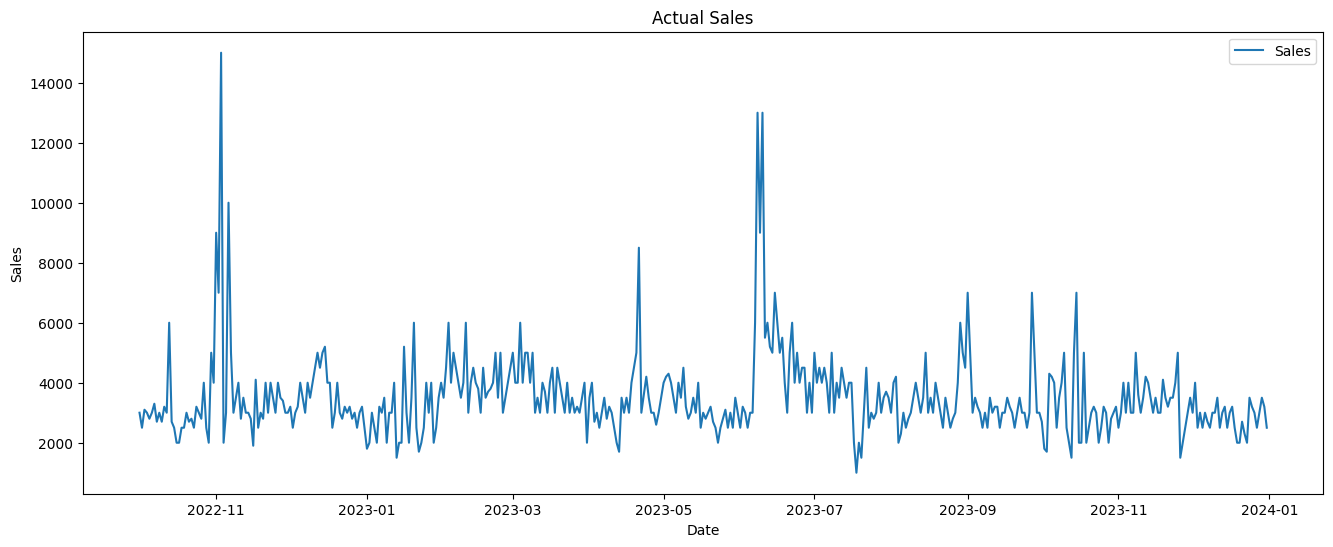

In [5]:
plt.figure(figsize=(16,6))
plt.plot(data['date'], data['sales'], label='Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual Sales')
plt.legend()
plt.show()

In [6]:
# Step 3: Train-Test Split
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

In [7]:
# Step 4: Scale Data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['sales']])
test_scaled = scaler.transform(test_data[['sales']])

In [8]:
def prepare_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = prepare_sequences(train_scaled, seq_length)
X_test, y_test = prepare_sequences(test_scaled, seq_length)

In [9]:
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Step 7: Compile Model
model.compile(optimizer='adam', loss='mse')

In [10]:
# Step 8: Train Model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
11/11 [==============================] - 2s 8ms/step - loss: 0.0287
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0137
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0107
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0105
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0104
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 11/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 12/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 13/50
11/11 [==============================

In [11]:
loss = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', loss)

Test Loss: 0.002689006505534053
2/2 [==============================] - 0s 5ms/step


In [14]:
# Initialize an array to store the predicted sales
sales_predictions = []

# Use the last sequence from the test set as the initial input for prediction
last_sequence = X_test[-1]

# Iterate over the next 30 days to predict each day's sales
for _ in range(30):
    # Predict the next day's sales using the model
    next_day_sales = model.predict(last_sequence.reshape(1, seq_length, 1))
    sales_predictions.append(next_day_sales[0][0])
    # Shift the sequence by one day, adding the predicted sales
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1] = next_day_sales[0]

# Inverse transform the predicted sales
sales_predictions = scaler.inverse_transform(np.array(sales_predictions).reshape(-1, 1))

# Print the predicted sales for the next 30 days
print("Predicted Sales for the next 30 days:")
for i, prediction in enumerate(sales_predictions, start=1):
    print(f"Day {i}: {prediction[0]}")

1/1 [==============================] - 0s 17ms/step
Predicted Sales for the next 30 days:
Day 1: 3518.992431640625
Day 2: 3600.39697265625
Day 3: 3669.861572265625
Day 4: 3727.000244140625
Day 5: 3771.491455078125
Day 6: 3804.10986328125
Day 7: 3826.11572265625
Day 8: 3839.13623046875
Day 9: 3844.85009765625
Day 10: 3844.857177734375
Day 11: 3840.675048828125
Day 12: 3833.5927734375
Day 13: 3824.79052734375
Day 14: 3815.103271484375
Day 15: 3805.24365234375
Day 16: 3795.775634765625
Day 17: 3787.01123046875
Day 18: 3779.191650390625
Day 19: 3772.481689453125
Day 20: 3766.91650390625
Day 21: 3762.45263671875
Day 22: 3758.982177734375
Day 23: 3756.448974609375
Day 24: 3754.734130859375
Day 25: 3753.62939453125
Day 26: 3753.07958984375
Day 27: 3752.96484375
Day 28: 3753.19677734375
Day 29: 3753.6416015625
Day 30: 3754.215087890625


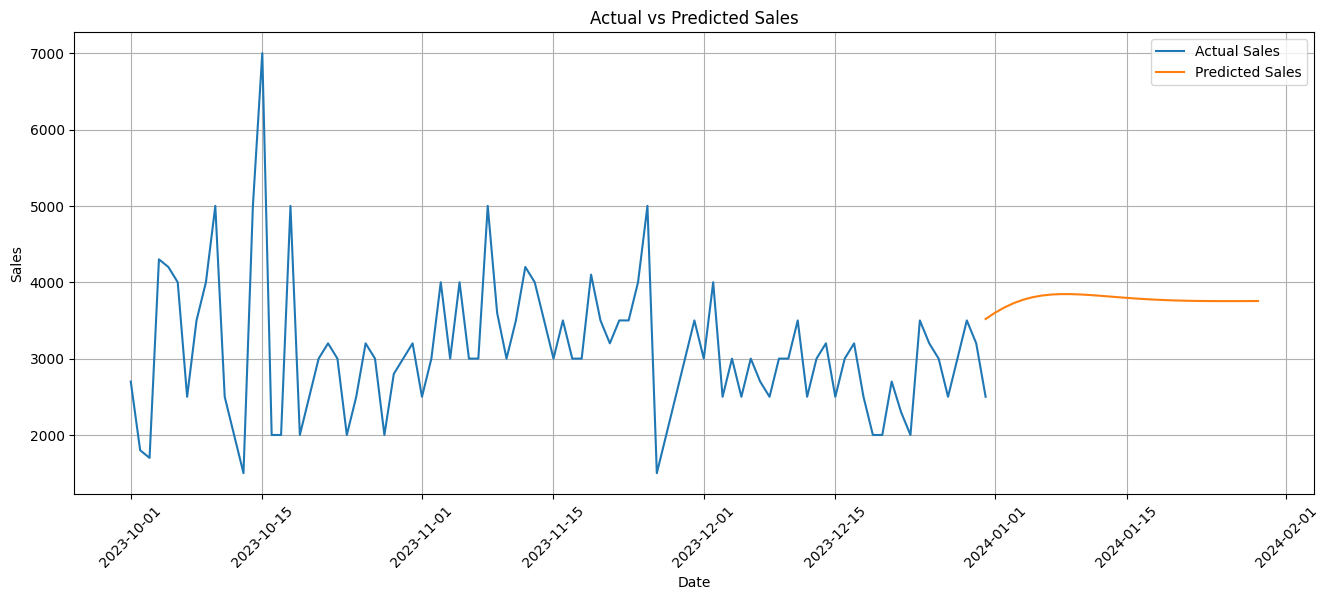

In [15]:
# Extract actual sales data for the test set
actual_sales = test_data['sales'].values

# Create an array of dates for the next 30 days
next_30_days_dates = pd.date_range(test_data['date'].iloc[-1], periods=30)

plt.figure(figsize=(16,6))
plt.plot(test_data['date'], actual_sales, label='Actual Sales')
plt.plot(next_30_days_dates, sales_predictions, label='Predicted Sales')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()